In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

In [11]:
data = pd.read_csv("../student_success_survey.csv")

In [12]:


import sys
import os
import pandas as pd

# Step 1: Add the script's directory to the Python path.
# This creates a correct relative path from your notebook to the script's folder.
feature_engineer_path = os.path.abspath(os.path.join('..', 'feature_engineer(task3)'))
if feature_engineer_path not in sys.path:
    sys.path.append(feature_engineer_path)

# Step 2: Now you can import functions from your .py file.
from feature_engineer import run_full_pipeline, engineer_behavioral_features



In [13]:
df = run_full_pipeline(data)

In [14]:
df.head()

,cgpa,is_cgpa_missing,prereq_ct_grade,used_pytorch_tensorflow,laptop_or_cloud_ready,total_grit_score,hidden_knowledge_score,study_friction_index,is_logistics_missing,python_confidence_gap,pillar year,final_course_score
0,4.62,0,A/A+,Yes,Yes,3.500000,2,0.218750,0,3.0000,ASD final year,83.0
1,4.00,0,A-,No,Yes,2.666667,2,0.750000,0,0.6800,ASD 3rd year student,65.9
2,4.13,0,B+,No,Yes,2.666667,3,0.555556,0,1.6800,ASD 3rd year student,80.3
3,4.69,0,A/A+,Yes,Yes,2.000000,3,0.645833,0,-0.3200,ISTD 3rd year student,71.1
4,4.63,0,A/A+,Yes,Yes,3.166667,1,0.156250,0,2.9044,ISTD final year,68.2


In [15]:
# df["prereq_ct_grade"].value_counts()

In [16]:
df[df.isnull().any(axis=1)]

,cgpa,is_cgpa_missing,prereq_ct_grade,used_pytorch_tensorflow,laptop_or_cloud_ready,total_grit_score,hidden_knowledge_score,study_friction_index,is_logistics_missing,python_confidence_gap,pillar year,final_course_score


In [17]:
def prepare_data(df, target_col='final_course_score'):
    """
    Prepare the data for training
    """
    # Make a copy to avoid modifying original
    df_processed = df.copy()
    
    # Handle categorical variables
    # 1. Encode 'prereq_ct_grade' (ordinal encoding - grades have natural order)
    grade_mapping = {
        'Exempted/Di': 3.75, 'C+ or lower': 2.5,  'B-': 2.7, 'B': 3.5, 
        'B+': 4.0, 'A-': 4.5, 'A/A+': 5  # Average of A and A+
    }
    df_processed['prereq_ct_grade_encoded'] = df_processed['prereq_ct_grade'].map(grade_mapping)
    
    # 2. Encode binary categorical variables
    binary_mapping = {'Yes': 1, 'No': 0}
    df_processed['used_pytorch_tensorflow_enc'] = df_processed['used_pytorch_tensorflow'].map(binary_mapping)
    df_processed['laptop_or_cloud_ready_enc'] = df_processed['laptop_or_cloud_ready'].map(binary_mapping)
    
    # 3. Encode 'pillar year' (combination of pillar and year)
    # Extract pillar and year information
    df_processed['pillar'] = df_processed['pillar year'].apply(lambda x: x.split()[0])
    df_processed['year'] = df_processed['pillar year'].apply(lambda x: 'final' if 'final' in x else '3rd')
    
    # One-hot encode pillar
    pillar_dummies = pd.get_dummies(df_processed['pillar'], prefix='pillar')
    year_dummies = pd.get_dummies(df_processed['year'], prefix='year')
    
    # Combine all features
    feature_cols = ['cgpa', 'prereq_ct_grade_encoded', 'used_pytorch_tensorflow_enc', 
                    'laptop_or_cloud_ready_enc', 'total_grit_score', 'hidden_knowledge_score',
                    'study_friction_index', 'python_confidence_gap']
    
    # Add dummy variables
    X = pd.concat([df_processed[feature_cols], pillar_dummies, year_dummies], axis=1)
    y = df_processed[target_col]
    
    return X, y

# Prepare the data

In [18]:


# Step 1: Data Preprocessing

X, y = prepare_data(df)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)





In [19]:
# Step 2: Define the Linear Model
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)  # Single linear layer
        
    def forward(self, x):
        return self.linear(x)

# Get input dimension
input_dim = X_train_scaled.shape[1]
model = LinearRegressionModel(input_dim)

# Step 3: Training setup
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [20]:
# Step 4: Training loop
def train_model(model, train_loader, criterion, optimizer, epochs=100):
    train_losses = []
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for batch_X, batch_y in train_loader:
            # Forward pass
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
    
    return train_losses

# Train the model
print("Training the model...")
train_losses = train_model(model, train_loader, criterion, optimizer, epochs=100)



Training the model...
Epoch [20/100], Loss: 2923.6439
Epoch [40/100], Loss: 1435.4083
Epoch [60/100], Loss: 559.8586
Epoch [80/100], Loss: 163.4177
Epoch [100/100], Loss: 68.2936



Test Set Metrics:
Mean Squared Error: 44.0084
Root Mean Squared Error: 6.6339
Mean Absolute Error: 5.0736


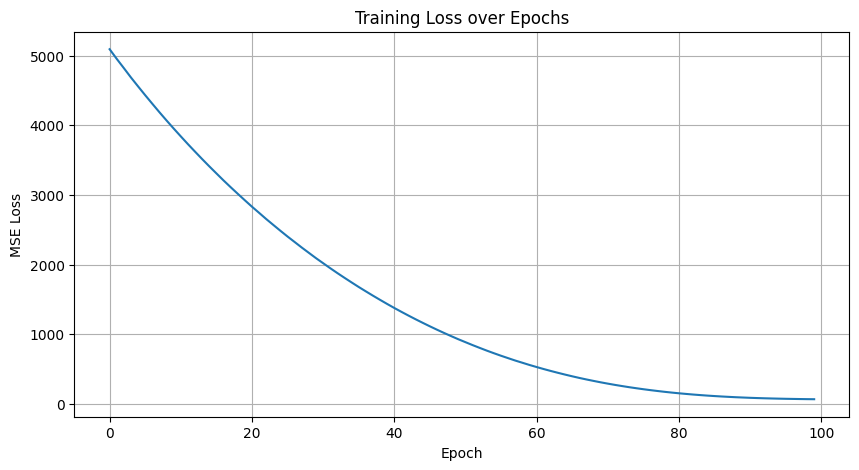

In [21]:
# Step 5: Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            predictions.extend(outputs.numpy().flatten())
            actuals.extend(batch_y.numpy().flatten())
    
    return np.array(predictions), np.array(actuals)

# Make predictions
predictions, actuals = evaluate_model(model, test_loader)

# Calculate metrics
mse = np.mean((predictions - actuals) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(predictions - actuals))

print(f"\nTest Set Metrics:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()





In [22]:
# Step 6: Make predictions on new data
def predict_new_data(model, scaler, new_data_df):
    """
    Make predictions on new data
    """
    # Preprocess new data (same steps as training data)
    X_new, _ = prepare_data(new_data_df)
    
    # Ensure columns match training data
    X_new = X_new[X.columns]  # Use same columns as training
    
    # Scale
    X_new_scaled = scaler.transform(X_new)
    X_new_tensor = torch.FloatTensor(X_new_scaled)
    
    # Predict
    model.eval()
    with torch.no_grad():
        predictions = model(X_new_tensor)
    
    return predictions.numpy().flatten()

# Example: Make predictions on the training data (just for demonstration)

In [24]:
df.iloc[0:5]  # Show first 5 rows of original data for reference

,cgpa,is_cgpa_missing,prereq_ct_grade,used_pytorch_tensorflow,laptop_or_cloud_ready,total_grit_score,hidden_knowledge_score,study_friction_index,is_logistics_missing,python_confidence_gap,pillar year,final_course_score
0,4.62,0,A/A+,Yes,Yes,3.500000,2,0.218750,0,3.0000,ASD final year,83.0
1,4.00,0,A-,No,Yes,2.666667,2,0.750000,0,0.6800,ASD 3rd year student,65.9
2,4.13,0,B+,No,Yes,2.666667,3,0.555556,0,1.6800,ASD 3rd year student,80.3
3,4.69,0,A/A+,Yes,Yes,2.000000,3,0.645833,0,-0.3200,ISTD 3rd year student,71.1
4,4.63,0,A/A+,Yes,Yes,3.166667,1,0.156250,0,2.9044,ISTD final year,68.2



PROPER MODEL EVALUATION ON TEST DATA

Test Set Performance Metrics:
Mean Squared Error (MSE): 44.0084
Root Mean Squared Error (RMSE): 6.6339
Mean Absolute Error (MAE): 5.0736
R² Score: 0.5032

Test Sample Predictions:
Test Sample 1: Predicted = 74.38, Actual = 85.00, Error = 10.62
Test Sample 2: Predicted = 68.98, Actual = 75.70, Error = 6.72
Test Sample 3: Predicted = 68.21, Actual = 57.70, Error = 10.51
Test Sample 4: Predicted = 68.26, Actual = 74.20, Error = 5.94
Test Sample 5: Predicted = 64.95, Actual = 69.10, Error = 4.15
Test Sample 6: Predicted = 73.24, Actual = 71.00, Error = 2.24
Test Sample 7: Predicted = 76.10, Actual = 65.60, Error = 10.50
Test Sample 8: Predicted = 74.10, Actual = 72.50, Error = 1.60
Test Sample 9: Predicted = 78.19, Actual = 70.70, Error = 7.49
Test Sample 10: Predicted = 74.98, Actual = 73.50, Error = 1.48
Test Sample 11: Predicted = 61.84, Actual = 63.00, Error = 1.16
Test Sample 12: Predicted = 70.96, Actual = 74.90, Error = 3.94
Test Sample 13: Pre

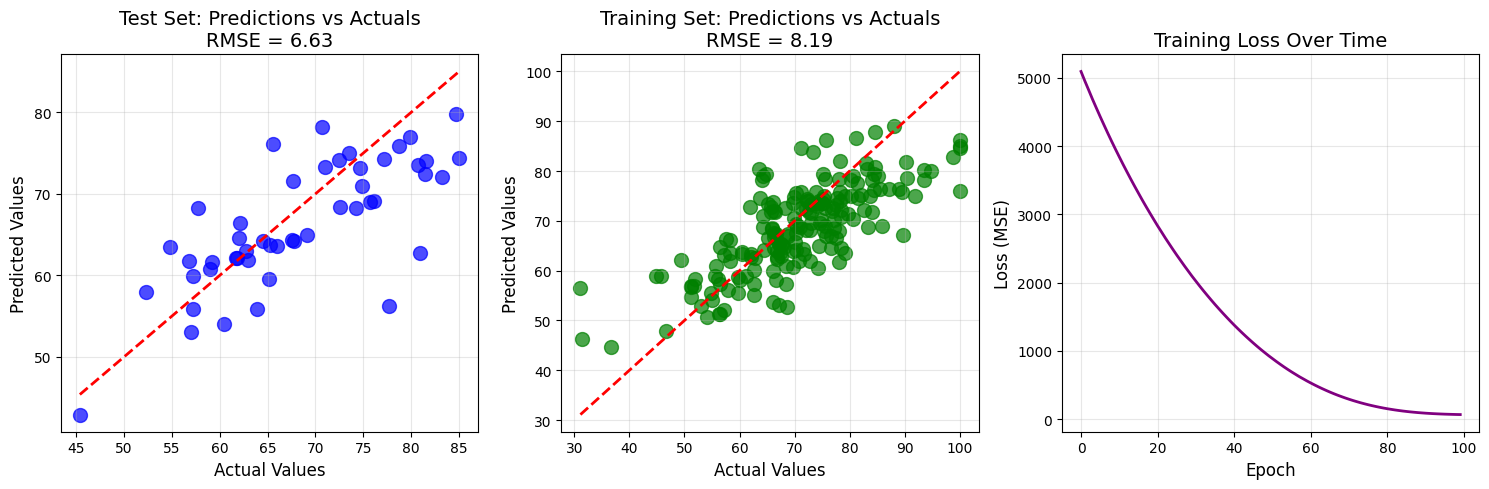


FEATURE IMPORTANCE ANALYSIS

Feature Coefficients (magnitude indicates importance):
                    Feature  Coefficient  Abs_Coefficient
                       cgpa     4.600395         4.600395
     hidden_knowledge_score     4.508691         4.508691
           total_grit_score     3.394485         3.394485
       study_friction_index    -1.356474         1.356474
      python_confidence_gap     1.137030         1.137030
used_pytorch_tensorflow_enc     0.950910         0.950910
  laptop_or_cloud_ready_enc     0.874830         0.874830
                pillar_ISTD    -0.873510         0.873510
               pillar_Other     0.725062         0.725062
                   year_3rd     0.519502         0.519502
                 pillar_ASD     0.390856         0.390856
    prereq_ct_grade_encoded     0.376478         0.376478
                 pillar_EPD     0.293061         0.293061
                 year_final    -0.116542         0.116542
                 pillar_ESD    -0.062892     

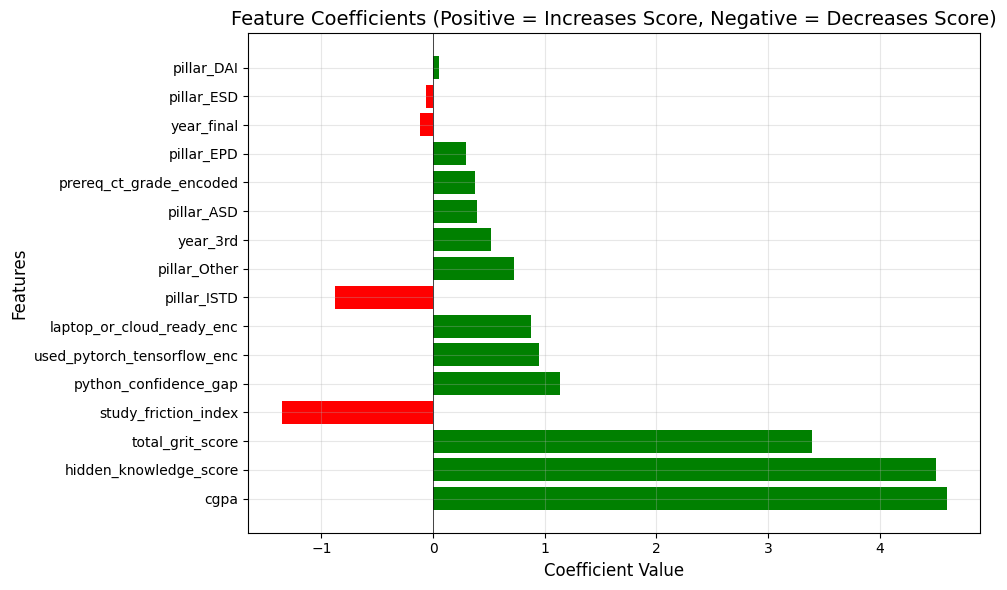


PREDICTIONS ON NEW DATA


In [25]:
# After training the model, evaluate properly on TEST data only

print("\n" + "="*60)
print("PROPER MODEL EVALUATION ON TEST DATA")
print("="*60)

# Get test set predictions using the test loader
model.eval()
test_predictions = []
test_actuals = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        test_predictions.extend(outputs.numpy().flatten())
        test_actuals.extend(batch_y.numpy().flatten())

# Convert to numpy arrays
test_predictions = np.array(test_predictions)
test_actuals = np.array(test_actuals)

# Calculate test metrics
test_mse = np.mean((test_predictions - test_actuals) ** 2)
test_rmse = np.sqrt(test_mse)
test_mae = np.mean(np.abs(test_predictions - test_actuals))
test_r2 = 1 - (np.sum((test_actuals - test_predictions) ** 2) / np.sum((test_actuals - np.mean(test_actuals)) ** 2))

print(f"\nTest Set Performance Metrics:")
print(f"Mean Squared Error (MSE): {test_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {test_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {test_mae:.4f}")
print(f"R² Score: {test_r2:.4f}")

# Show individual test sample predictions
print(f"\nTest Sample Predictions:")
for i, (pred, actual) in enumerate(zip(test_predictions, test_actuals)):
    error = abs(pred - actual)
    print(f"Test Sample {i+1}: Predicted = {pred:.2f}, Actual = {actual:.2f}, Error = {error:.2f}")

# OPTIONAL: If you want to see training performance for comparison (not for evaluation)
print("\n" + "="*60)
print("TRAINING SET PERFORMANCE (FOR COMPARISON ONLY - NOT FOR EVALUATION)")
print("="*60)

# Get training predictions
model.eval()
train_predictions = []
train_actuals = []

with torch.no_grad():
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        train_predictions.extend(outputs.numpy().flatten())
        train_actuals.extend(batch_y.numpy().flatten())

train_predictions = np.array(train_predictions)
train_actuals = np.array(train_actuals)

# Calculate training metrics
train_mse = np.mean((train_predictions - train_actuals) ** 2)
train_rmse = np.sqrt(train_mse)

print(f"\nTraining Set Metrics:")
print(f"MSE: {train_mse:.4f}")
print(f"RMSE: {train_rmse:.4f}")
print(f"\nComparison: Training RMSE = {train_rmse:.4f} vs Test RMSE = {test_rmse:.4f}")

# Visualize predictions vs actuals
plt.figure(figsize=(15, 5))

# Test set plot
plt.subplot(1, 3, 1)
plt.scatter(test_actuals, test_predictions, color='blue', s=100, alpha=0.7)
plt.plot([min(test_actuals), max(test_actuals)], 
         [min(test_actuals), max(test_actuals)], 'r--', linewidth=2)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title(f'Test Set: Predictions vs Actuals\nRMSE = {test_rmse:.2f}', fontsize=14)
plt.grid(True, alpha=0.3)

# Training set plot
plt.subplot(1, 3, 2)
plt.scatter(train_actuals, train_predictions, color='green', s=100, alpha=0.7)
plt.plot([min(train_actuals), max(train_actuals)], 
         [min(train_actuals), max(train_actuals)], 'r--', linewidth=2)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title(f'Training Set: Predictions vs Actuals\nRMSE = {train_rmse:.2f}', fontsize=14)
plt.grid(True, alpha=0.3)

# Training loss curve
plt.subplot(1, 3, 3)
plt.plot(train_losses, color='purple', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training Loss Over Time', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Feature importance analysis
print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Get feature names and coefficients
feature_names = X.columns.tolist()
coefficients = model.linear.weight.detach().numpy().flatten()

# Create feature importance dataframe
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

print("\nFeature Coefficients (magnitude indicates importance):")
print(feature_importance.to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 6))
colors = ['red' if c < 0 else 'green' for c in feature_importance['Coefficient']]
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color=colors)
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Coefficients (Positive = Increases Score, Negative = Decreases Score)', fontsize=14)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Make predictions on new data (if you have any)
print("\n" + "="*60)
print("PREDICTIONS ON NEW DATA")
print("="*60)

# Example: Create a new sample for prediction


In [ ]:
# Function to get feature importance (for linear model, coefficients indicate importance)
def get_feature_importance(model, feature_names):
    weights = model.linear.weight.detach().numpy().flatten()
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'coefficient': weights,
        'abs_coefficient': np.abs(weights)
    }).sort_values('abs_coefficient', ascending=False)
    return feature_importance

feature_importance = get_feature_importance(model, X.columns.tolist())
print(f"\nFeature Importance (based on coefficient magnitude):")
print(feature_importance)